In [314]:
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../'))
os.chdir(project_root)

import sys
sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import CCY_PAIRS, START_DATE, END_DATE
from src.data_utils import get_fx_data, compute_log_ret, to_binary, to_float, get_min_max_info
from src.models.rbm import get_synthetic_series

In [316]:
df = get_fx_data(CCY_PAIRS, START_DATE, END_DATE, df=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

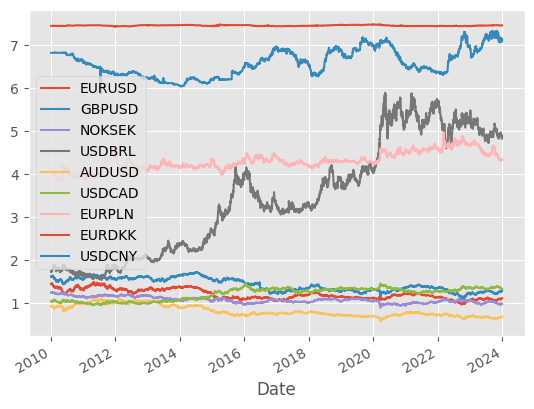

In [317]:
df.plot()

In [318]:
log_ret_df = compute_log_ret(df)

In [319]:
features = to_binary(log_ret_df)

In [320]:
features.sample(5)

EURUSD_01  EURUSD_02  EURUSD_03  EURUSD_04  EURUSD_05  EURUSD_06  \
475           0          0          1          1          1          0   
1755          0          1          1          1          1          1   
1351          1          0          0          1          1          1   
2079          0          1          1          1          1          0   
3464          0          1          1          1          0          0   

      EURUSD_07  EURUSD_08  EURUSD_09  EURUSD_10  ...  USDCNY_07  USDCNY_08  \
475           0          1          0          1  ...          0          0   
1755          1          1          0          0  ...          1          0   
1351          1          0          1          0  ...          0          1   
2079          1          1          1          0  ...          0          0   
3464          0          1          0          0  ...          1          0   

      USDCNY_09  USDCNY_10  USDCNY_11  USDCNY_12  USDCNY_13  USDCNY_14  \
475           1          0          0          1          1          0   
1755          0          0          1          1          0          1   
1351          0          0          0          0          0          1   
2079          0          1          1          0          0          0   
3464          0          0          1          1          0          0   

      USDCNY_15  USDCNY_16  
475           0          1  
1755          0          1  
1351          1          1  
2079          1          1  
3464          1          0  

[5 rows x 144 columns]

In [349]:
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(n_components=256, 
                   learning_rate=0.01, 
                   batch_size=50, 
                   n_iter=50, 
                   random_state=42, 
                   verbose=1)

rbm.fit(features.to_numpy())

[BernoulliRBM] Iteration 1, pseudo-likelihood = -96.22, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -96.22, time = 0.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -96.27, time = 0.15s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -96.33, time = 0.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -96.26, time = 0.15s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -96.16, time = 0.16s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -96.15, time = 0.18s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -96.11, time = 0.16s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -95.90, time = 0.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -96.03, time = 0.17s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -95.96, time = 0.18s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -95.81, time = 0.14s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -95.48, time = 0.16s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -95.33, time = 0.14s
[BernoulliRBM] Iteration 15, 

BernoulliRBM(batch_size=50, learning_rate=0.01, n_iter=50, random_state=42,
             verbose=1)

In [350]:
synth_df = get_synthetic_series(rbm=rbm, log_ret_df=log_ret_df, pairs=features.columns, n_samples=1000)

In [351]:
last_date = df.index[-1]
synth_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=synth_df.shape[0], freq='D')

synth_df.index = synth_dates

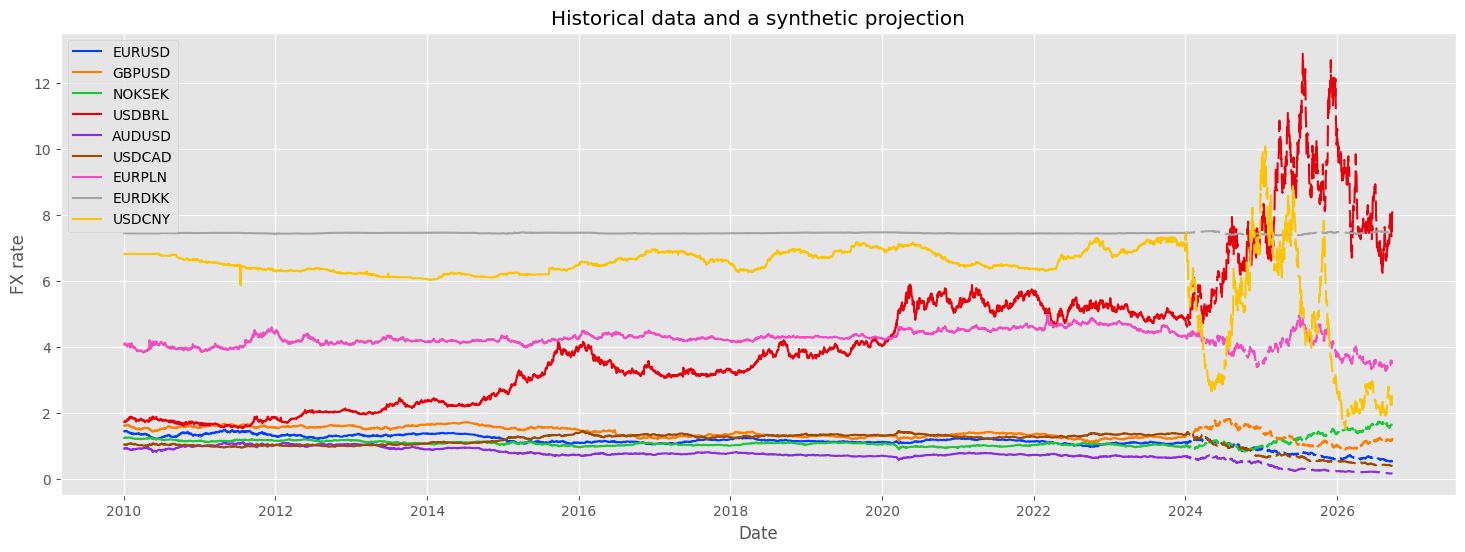

In [352]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
palette = sns.color_palette('bright', len(df.columns))

for i, column in enumerate(df.columns):
    ax.plot(df.index, df[column], label=f'{column}', color=palette[i])

for i, column in enumerate(synth_df.columns):
    ax.plot(synth_df.index, synth_df[column], linestyle=(5, (10, 3)), color=palette[i])

# Adding labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('FX rate')
ax.set_title('Historical data and a synthetic projection')
ax.legend()

# Show plot
plt.show()

In [353]:
palette = sns.color_palette('bright', len(df.columns))
colors = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b in palette]

data_traces = []
for i, column in enumerate(df.columns):
    trace = go.Scatter(
        x=df.index,
        y=df[column],
        mode='lines',
        name=f'{column}',
        line=dict(color=colors[i]),
        legendgroup=column  # Assigning the same legendgroup for each pair of actual and synthetic traces
    )
    data_traces.append(trace)

# Create traces for synthetic data
synth_traces = []
for i, column in enumerate(synth_df.columns):
    trace = go.Scatter(
        x=synth_df.index,
        y=synth_df[column],
        mode='lines',
        name=f'Synthetic {column}',
        line=dict(dash='dash', color=colors[i]),
        showlegend=False,  # Synthetic traces won't appear in the legend
        legendgroup=column  # Assigning the same legendgroup for each pair of actual and synthetic traces
    )
    synth_traces.append(trace)

all_traces = data_traces + synth_traces

layout = go.Layout(
    title='Historical data and a synthetic projection',
    xaxis=dict(title='Date'),
    yaxis=dict(title='FX rate'),
)

fig = go.Figure(data=all_traces, layout=layout)
pio.show(fig)